### Recap on (Damped) Harmonic Oscillators

In classical mechanics, a harmonic oscillator is a system in which a mass experiences a restoring force proportional to its displacement from equilibrium. If we let $x$ be the displacement of the mass $m$ from the equilibrium $x=0$, by the Hooke's law, the restoring force $F_r$ has the following form:

$$F_r=-kx.$$

Also, from the Newton's second law of motion $F=m\frac{\partial^2 x}{\partial t^2}$, where the second order derivative with respect to time $t$, we have the following relationship:

$$m\frac{\partial^2 x}{\partial t^2} + kx = 0.$$

In an ideal harmonic oscillator as in the above, the mass oscillates indefinitely with constant amplitude and frequency. However, real-world oscillators are often damped and experience a resistive or damping force that opposes its motion. This means that they gradually lose energy due to frictional or resistive forces, causing the oscillations to decrease in amplitude over time. Such a damping force, say $F_d$ can be modeled as being proportional to the velocity $\frac{\partial x}{\partial t}$ of the mass, or $F_d=-c\frac{\partial x}{\partial t}$, where $c$ is called the damping coefficient.

The Newton's second law for damped harmonic oscillators then becomes:

$$F_\text{total} = F_r + F_d = -kx-c\frac{\partial x}{\partial t} = m\frac{\partial^2 x}{\partial t^2},$$

which can be rewritten into a more intuitive form:

$$\frac{\partial^2 x}{\partial t^2} + 2\zeta\omega_0\frac{\partial x}{\partial t} + \omega_0^2 x = 0,$$

where $\omega_0:=\sqrt{\frac{k}{m}}$ is the angular frequency of the oscillator and $\zeta:=\frac{c}{2\sqrt{mk}}$ is called the damping ratio.

The value of the damping ratio can vary and critically determine the behavior of the system, affecting whether the system returns to equilibrium without oscillating (overdamping; $\zeta>1$), oscillates with a gradually reducing amplitude (underdamping; $\zeta<1$), or quickly comes to rest without oscillating (critical damping; $\zeta=1$).

Oftentimes, it is more convenient to use the state space representation of a damped harmonic oscillator, expressesing the system's dynamics using a set of first-order differential equations that describe its state at any given time. The state vector, typically represented by $\mathbf{x}(t)$, includes position $x$ and velocity $\dot{x}:=\frac{\partial x}{\partial t}$, which fully describe the system's current condition:

$$\mathbf{x}(t) = \begin{bmatrix} x(t) \\ \dot{x}(t) \end{bmatrix}.$$

Then the original second-order differential equation of the harmonic oscillator above then becomes a system of first-order differential equations:

$$\frac{d}{dt}\mathbf{x}(t)=\begin{bmatrix} 0 & 1 \\ -2\zeta\omega_0 & -\omega_0^2\end{bmatrix}\mathbf{x}(t)$$

where the matrix 
$$A:=\begin{bmatrix} 0 & 1 \\ -2\zeta\omega_0 & -\omega_0^2\end{bmatrix}$$
is called the system matrix.

Finally, in the underdamped or critically damped cases where $\zeta \leq 1$, the analytical solution for the state space representation of a damped harmonic oscillator can be expressed as damped sinusoidal oscillations:

$$\mathbf{x}(t) = ae^{-\zeta\omega_0 t}\sin(\sqrt{1-\zeta^2}\omega_0t + \varphi),$$

where the amplitude $a$ and phase $\varphi$ are coefficients determined from the initial conditions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate

import torch
import torch.nn as nn
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

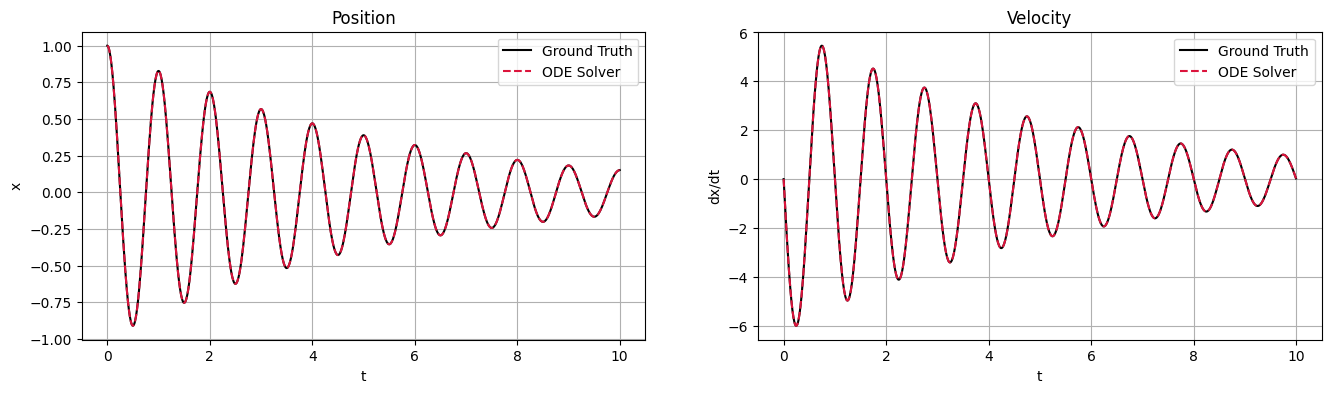

In [4]:
def ode(X, t, omega0, zeta):
    """
    X = [x, dx]: State vector
    omega0 = sqrt(k/m): Undamped angular frequency of the oscillator.
    beta = 0.5*c/sqrt(m*k): Damping ratio.
    """
    x, dx = X
    ddx = -2*zeta*omega0*dx - (omega0**2)*x
    return [dx, ddx]

omega0 = 2*np.pi
zeta = 0.03

Nt = 1000
t = np.linspace(0., 10., Nt)
X0 = np.array([1, 0])

# Ground Truth - Determine the amplitude a and phase phi from init cond.
if np.abs((X0[1] + zeta*omega0*X0[0])) < 1e-7:
    phi = 0.5*np.pi
else:
    phi = np.arctan(np.sqrt(1-zeta**2)*omega0*X0[0]/(X0[1] + zeta*omega0*X0[0]))
a = X0[0]/np.sin(phi)

GT = np.array([
    a*np.exp(-zeta*omega0*t)*np.sin(np.sqrt(1-zeta**2)*omega0*t + phi),
    -a*zeta*omega0*np.exp(-zeta*omega0*t)*np.sin(np.sqrt(1-zeta**2)*omega0*t + phi) + a*np.exp(-zeta*omega0*t)*np.sqrt(1-zeta**2)*omega0*np.cos(np.sqrt(1-zeta**2)*omega0*t + phi),
]).T

# Numerical Solution - ODE Solver
X = integrate.odeint(ode, X0, t, args = (omega0, zeta))

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(t, GT[:,0], color='black', label = "Ground Truth")
plt.plot(t, X[:,0], color='crimson', linestyle='dashed', label = "ODE Solver")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.title('Position')
plt.legend()
plt.subplot(1,2,2)
plt.plot(t, GT[:,1], color='black', label = "Ground Truth")
plt.plot(t, X[:,1], color='crimson', linestyle='dashed', label = "ODE Solver")
plt.grid()
plt.xlabel("t")
plt.ylabel("dx/dt")
plt.title('Velocity')
plt.legend()

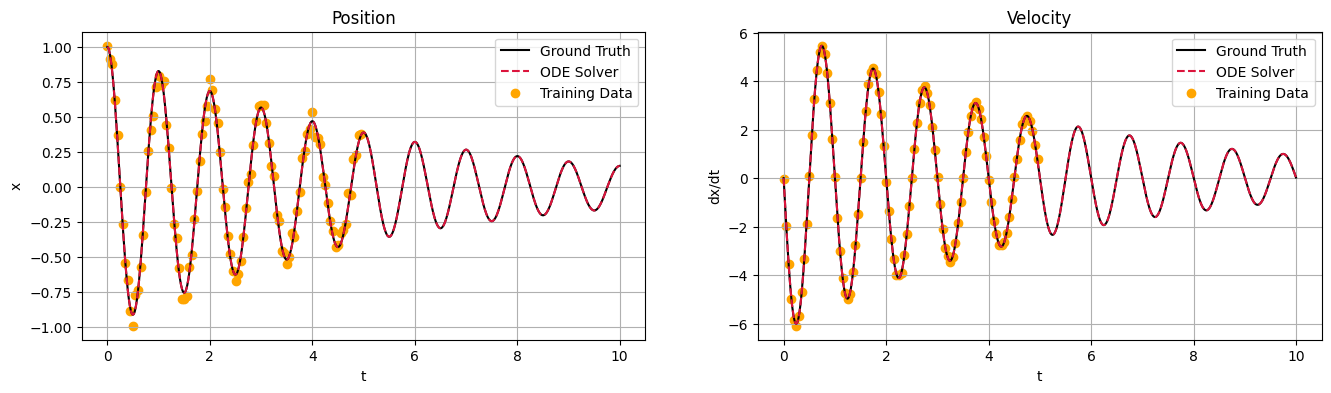

In [7]:
training_data = np.hstack((np.expand_dims(t[0:500:5], axis=-1), GT[0:500:5,:]))  # t, x, xdot
training_data[:,1] += np.random.randn(len(training_data))*0.05 # Emulate noisy observations
training_data[:,2] += np.random.randn(len(training_data))*0.05  #

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(t, GT[:,0], color='black', label = "Ground Truth")
plt.plot(t, X[:,0], color='crimson', linestyle='dashed', label = "ODE Solver")
plt.scatter(training_data[:,0], training_data[:,1], color='orange', label='Training Data')
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.title('Position')
plt.legend()
plt.subplot(1,2,2)
plt.plot(t, GT[:,1], color='black', label = "Ground Truth")
plt.plot(t, X[:,1], color='crimson', linestyle='dashed', label = "ODE Solver")
plt.scatter(training_data[:,0], training_data[:,2], color='orange', label='Training Data')
plt.grid()
plt.xlabel("t")
plt.ylabel("dx/dt")
plt.title('Velocity')
plt.legend()

In [ ]:
class Backbone(nn.Module):
    def __init__(self, dtype=torch.float32):
        super().__init__()

        self.fc1 = nn.Linear(1, 16, dtype=dtype)  # input dim = 1 (t)
        self.fc2 = nn.Linear(16, 64, dtype=dtype)  # hidden dims = 16, 64
        self.out = nn.Linear(64, 2, dtype=dtype)  # output dim = 2 (x, dx)

        self.dtype = dtype

    def forward(self, x):
        x = self.fc1(x)
        x = nn.LeakyReLU()(x) 
        x = self.fc2(x)
        x = nn.LeakyReLU()(x) 
        return self.out(x)
    
model = Backbone()

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
import os
save_dir = 'results/harmonic'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
MAX_ITER = 5000
for iter in range(MAX_ITER):
    optimizer.zero_grad()
    input = torch.tensor(training_data[:,:1], dtype=model.dtype)
    output = torch.tensor(training_data[:,1:], dtype=model.dtype)
    prediction = model(input)
    loss = torch.mean((output-prediction)**2)# use mean squared error
    loss.backward()
    optimizer.step()

    print(f"{iter}/{MAX_ITER} - loss: {loss.detach().numpy():.5f}", end='\r')
    
    # plot the result as training progresses
    if (iter+1) % 10 == 0: 
        
        prediction = model(torch.tensor(np.expand_dims(t,axis=-1), dtype=model.dtype)).detach()

        plt.figure(figsize=(16,4))
        plt.subplot(1,2,1)
        plt.plot(t, GT[:,0], color='black', label = "Ground Truth")
        plt.plot(t, X[:,0], color='crimson', linestyle='dashed', label = "ODE Solver")
        plt.plot(t, prediction[:,0], color='deepskyblue', label = "PINN")
        plt.scatter(training_data[:,0], training_data[:,1], color='orange', label='Training Data')
        plt.grid()
        plt.xlabel("t")
        plt.ylabel("x")
        plt.title('Position')
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(t, GT[:,1], color='black', label = "Ground Truth")
        plt.plot(t, X[:,1], color='crimson', linestyle='dashed', label = "ODE Solver")
        plt.plot(t, prediction[:,1], color='deepskyblue', label = "PINN")
        plt.scatter(training_data[:,0], training_data[:,2], color='orange', label='Training Data')
        plt.grid()
        plt.xlabel("t")
        plt.ylabel("dx/dt")
        plt.title('Velocity')
        plt.legend()
        
        file = os.path.join(save_dir, "nn_%.6i.png"%(iter+1))
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (iter+1) % 500 == 0: plt.show()
        else: plt.close("all")

from PIL import Image
fps = 20
imgs = [Image.open(file) for file in files]
imgs[0].save(fp="results/nn.gif", format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=True)


In [ ]:
class Backbone(nn.Module):
    def __init__(self, dtype=torch.float32):
        super().__init__()

        self.fc1 = nn.Linear(1, 32, dtype=dtype)  # input dim = 1 (t)
        self.fc2 = nn.Linear(32, 32, dtype=dtype)  # hidden dims = 32, 32, 32
        self.fc3 = nn.Linear(32, 32, dtype=dtype)  #
        self.out = nn.Linear(32, 1, dtype=dtype)  # output dim = 2 (x, dx)

        self.dtype = dtype

    def forward(self, x):
        x = self.fc1(x)
        x = nn.SiLU()(x)
        # x = nn.Tanh()(x) 
        # x = nn.ReLU()(x) 
        # x = nn.LeakyReLU()(x)
        x = self.fc2(x)
        x = nn.SiLU()(x)
        # x = nn.Tanh()(x) 
        # x = nn.ReLU()(x) 
        # x = nn.LeakyReLU()(x)
        x = self.fc3(x)
        x = nn.SiLU()(x)
        return self.out(x)
    
model = Backbone()

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
import os
save_dir = 'results/harmonic'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
MAX_ITER = 200000
N_COLLOCATION_POINTS = 50
input = torch.tensor(training_data[:,:1], dtype=model.dtype)  # t
output = torch.tensor(training_data[:,1:2], dtype=model.dtype) # x only
collocation_t = np.linspace(0,10.,N_COLLOCATION_POINTS)
collocation_pts = torch.tensor(np.expand_dims(collocation_t, axis=-1), dtype=model.dtype).requires_grad_(True)
vis_pts = torch.tensor(np.expand_dims(t,axis=-1), dtype=model.dtype).requires_grad_(True)
for iter in range(MAX_ITER):
    optimizer.zero_grad()
    prediction = model(input)
    data_loss = torch.mean((output-prediction)**2)
    
    prediction_colloc = model(collocation_pts)
    # dx  = torch.autograd.grad(prediction_colloc[:,0], collocation_pts, torch.ones_like(prediction_colloc[:,0]), create_graph=True)[0]
    # ddx  = torch.autograd.grad(prediction_colloc[:,1], collocation_pts, torch.ones_like(prediction_colloc[:,1]), create_graph=True)[0]
    # residual1 = dx - prediction_colloc[:,1]
    # residual2 = ddx + 2*zeta*omega0*dx + (omega0**2)*prediction_colloc[:,0]
    # physics_loss = torch.mean(residual1**2 + residual2**2)
    dx  = torch.autograd.grad(prediction_colloc, collocation_pts, torch.ones_like(prediction_colloc), create_graph=True)[0]
    ddx  = torch.autograd.grad(dx, collocation_pts, torch.ones_like(dx), create_graph=True)[0]
    residual = ddx + 2*zeta*omega0*dx + (omega0**2)*prediction_colloc
    physics_loss = torch.mean(residual**2)

    if iter < 10000:
        loss = data_loss + (1e-3)*physics_loss
    else:
        loss = data_loss + physics_loss
    loss.backward()
    optimizer.step()

    print(f"{iter+1}/{MAX_ITER} - loss: {loss.detach().numpy():.5f}, physics: {physics_loss.detach().numpy():.5f}", end='\r')
    
    # plot the result as training progresses
    if (iter+1) % 100 == 0: 
        
        prediction = model(vis_pts)
        dx  = torch.autograd.grad(prediction, vis_pts, torch.ones_like(prediction), create_graph=True)[0]
        prediction = prediction.detach()
        dx = dx.detach()

        plt.figure(figsize=(16,4))
        plt.subplot(1,2,1)
        plt.plot(t, GT[:,0], color='black', label = "Ground Truth")
        plt.plot(t, X[:,0], color='crimson', linestyle='dashed', label = "ODE Solver")
        plt.plot(t, prediction, color='deepskyblue', label = "PINN")
        plt.scatter(collocation_t, np.zeros_like(collocation_t), color='olive', label = "Collocation Points", s=10)
        plt.scatter(training_data[:,0], training_data[:,1], color='orange', label='Training Data')
        plt.grid()
        plt.xlabel("t")
        plt.ylabel("x")
        plt.title(f'Position (Iteration={iter+1})')
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(t, GT[:,1], color='black', label = "Ground Truth")
        plt.plot(t, X[:,1], color='crimson', linestyle='dashed', label = "ODE Solver")
        plt.plot(t, dx, color='deepskyblue', label = "PINN")
        plt.scatter(collocation_t, np.zeros_like(collocation_t), color='olive', label = "Collocation Points", s=10)
        plt.scatter(training_data[:,0], training_data[:,2], color='orange', label='Training Data')
        plt.grid()
        plt.xlabel("t")
        plt.ylabel("dx/dt")
        plt.title('Velocity')
        plt.legend()
        
        file = os.path.join(save_dir, "pinn_%.6i.png"%(iter+1))
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (iter+1) % 500 == 0: plt.show()
        else: plt.close("all")

from PIL import Image
fps = 20
imgs = [Image.open(file) for file in files]
imgs[0].save(fp="results/pinn.gif", format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=True)

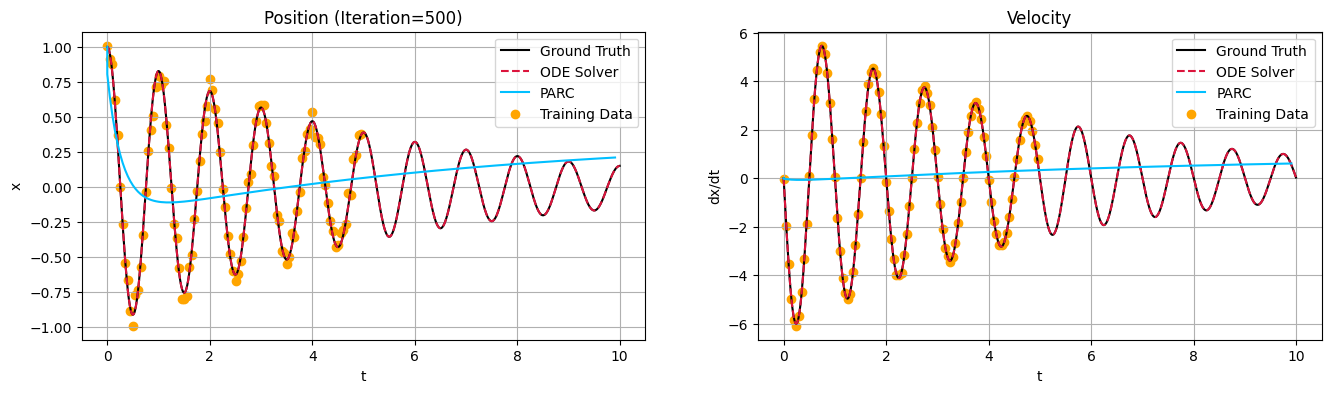

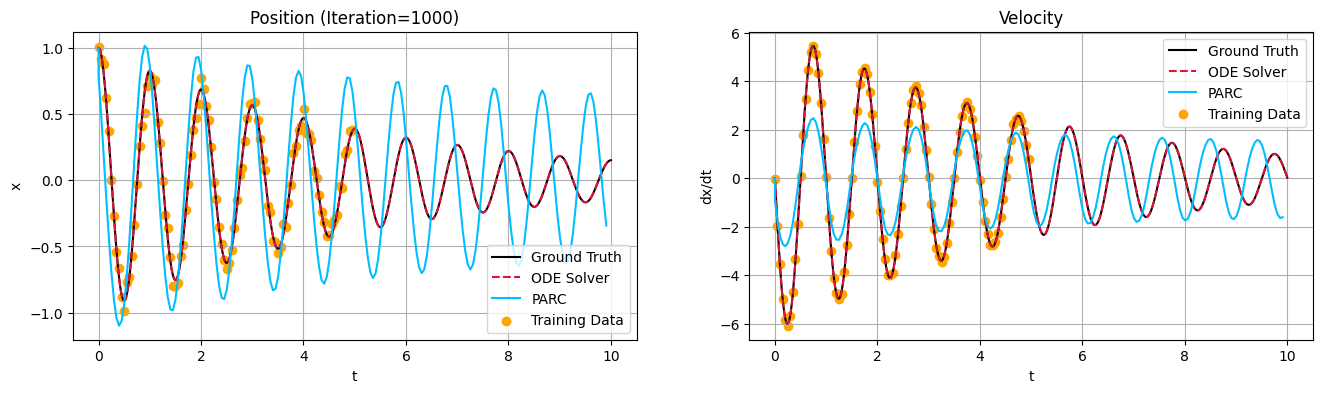

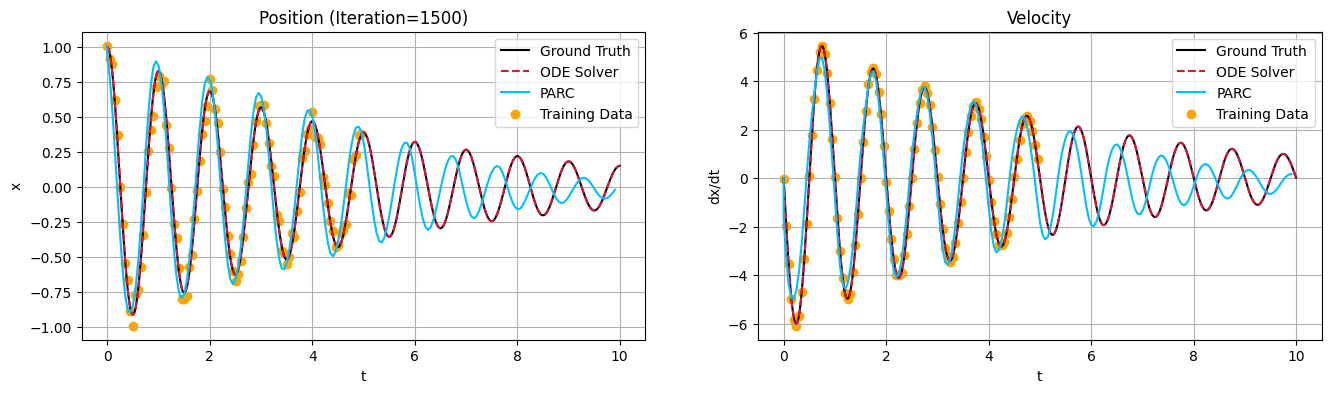

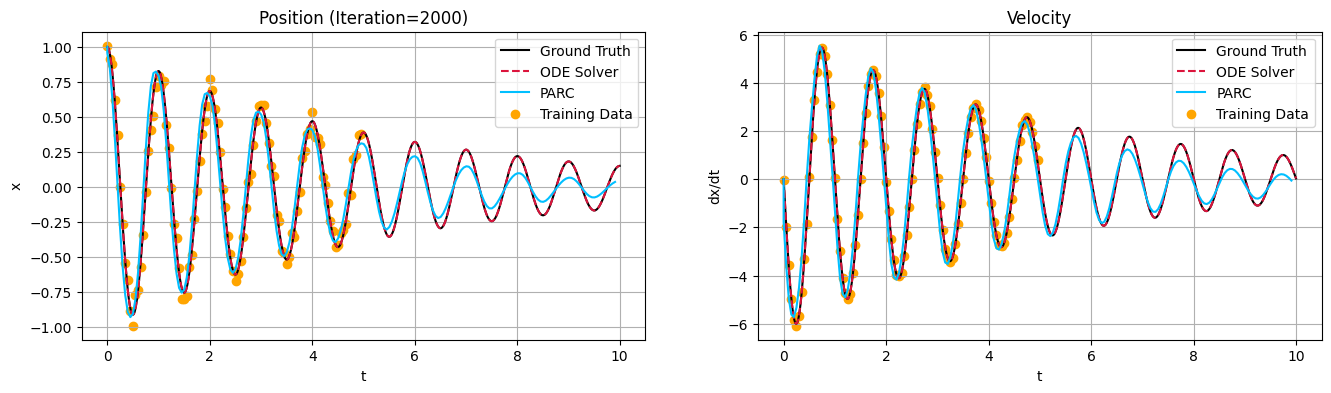

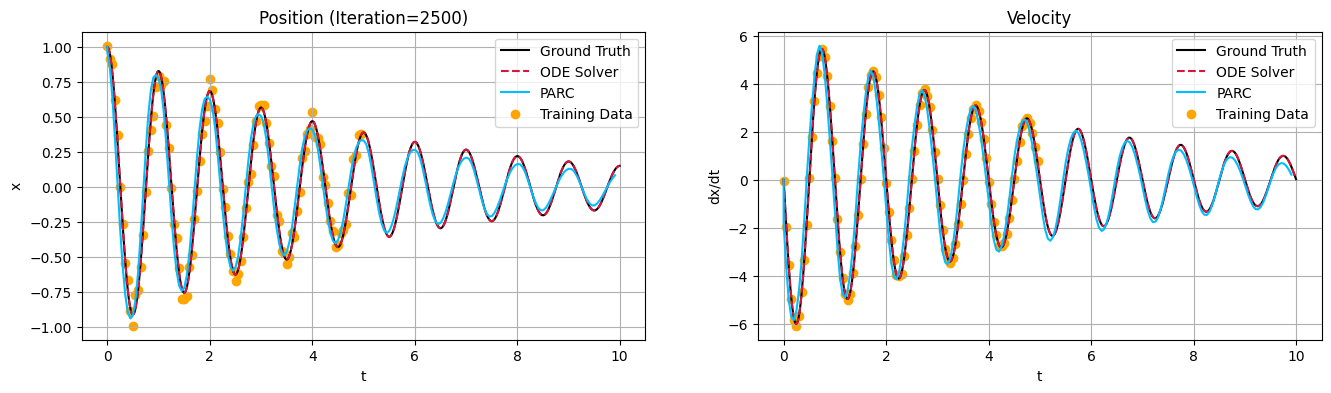

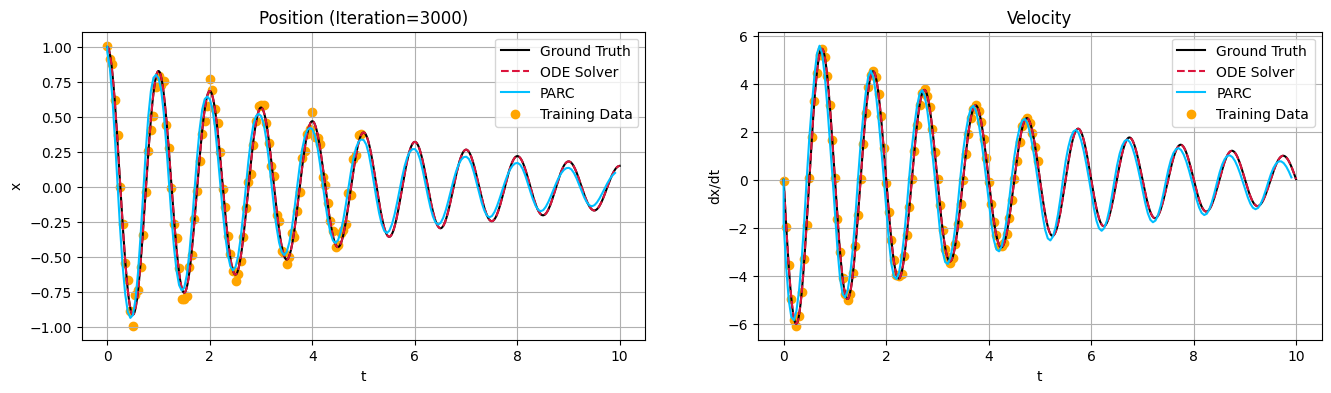

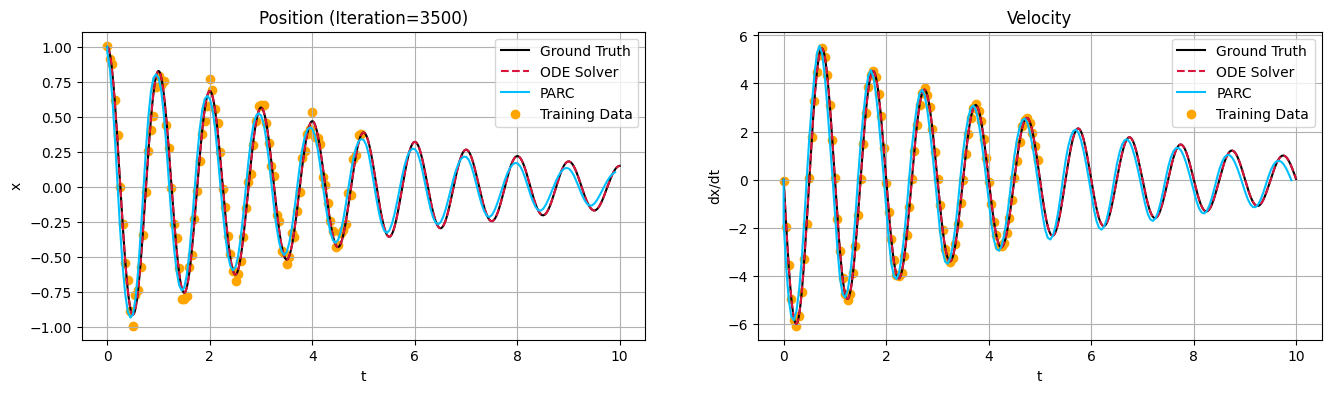

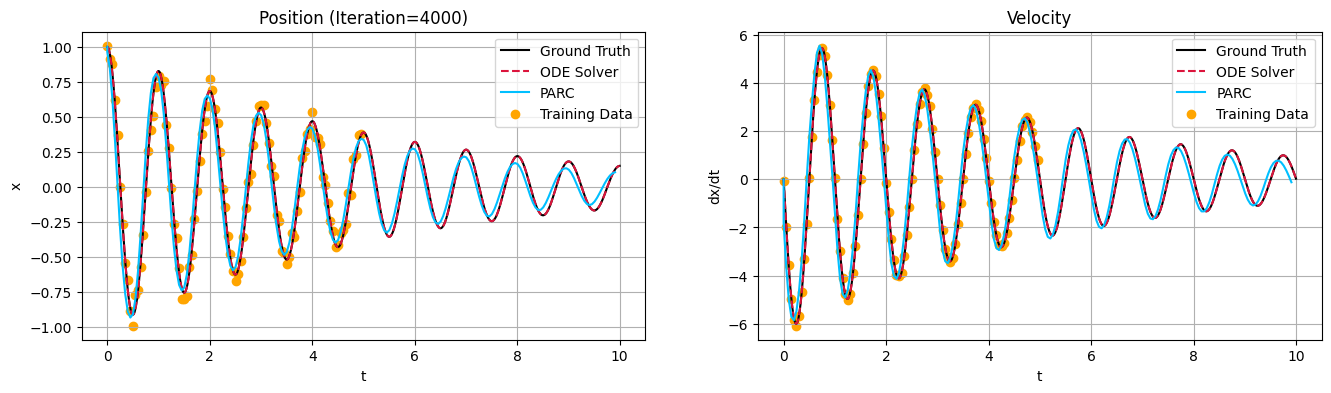

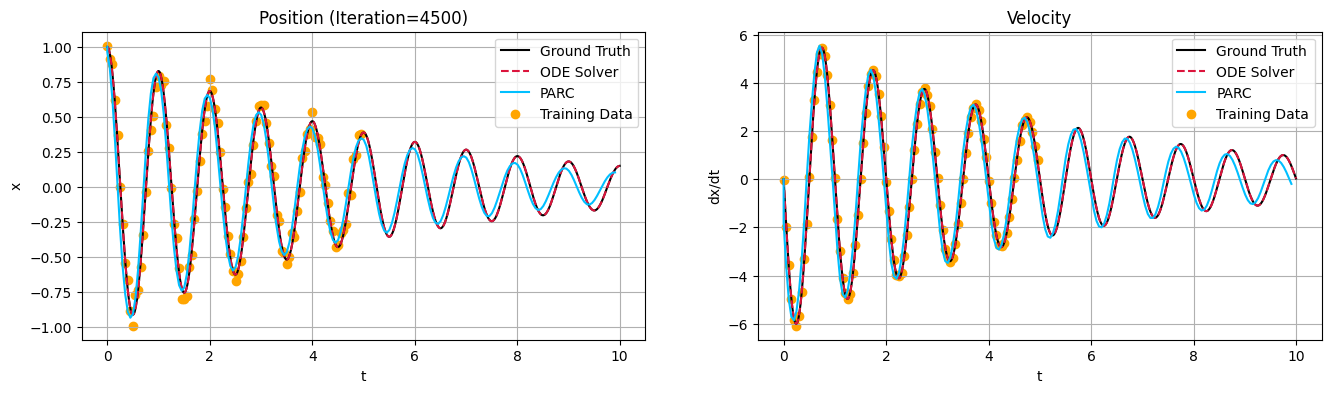

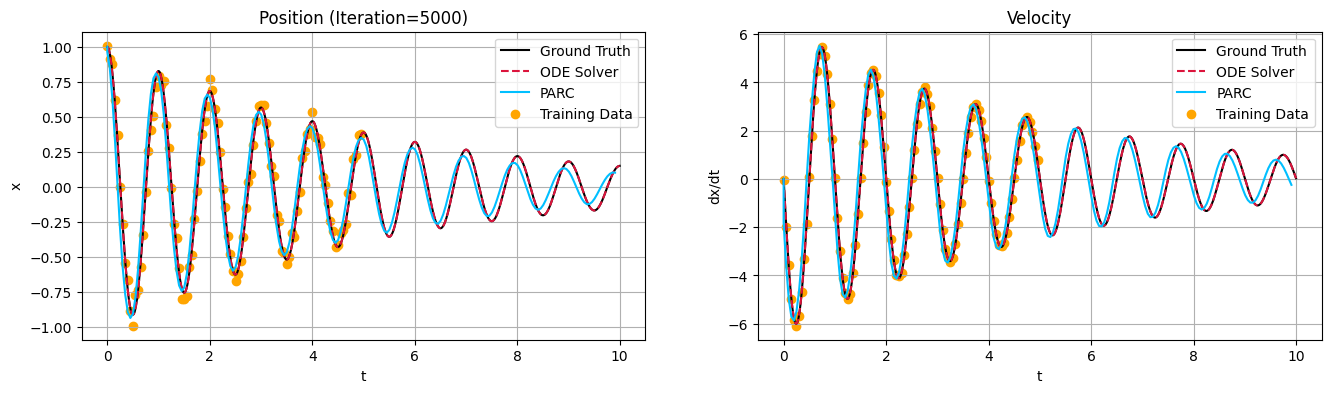

In [21]:
class Differentiator(nn.Module):
    def __init__(self, dtype=torch.float32):
        super().__init__()

        self.fc1 = nn.Linear(2, 16, dtype=dtype)  # input dim = 2 (x, dx)
        self.fc2 = nn.Linear(16, 32, dtype=dtype)  # hidden dims = 16, 32
        self.out = nn.Linear(32, 2, dtype=dtype)  # output dim = 2 (dx, ddx)

        self.dtype = dtype

    def forward(self, x):
        x = self.fc1(x)
        x = nn.SiLU()(x) 
        # x = nn.LeakyReLU()(x) 
        x = self.fc2(x)
        x = nn.SiLU()(x) 
        # x = nn.LeakyReLU()(x) 
        return self.out(x)
    
diff = Differentiator()


optimizer = torch.optim.Adam(diff.parameters(),lr=1e-3)
files = []
import os
save_dir = 'results/harmonic'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
MAX_ITER = 5000
dt = torch.tensor(training_data[1,0], dtype=model.dtype)
for iter in range(MAX_ITER):
    optimizer.zero_grad()
    x = torch.tensor(X0, dtype=model.dtype)
    for i in range(len(training_data)-1):
        pred_dx = diff(x)
        x = x + pred_dx*dt
        if i == 0:
            loss = (x[0] - torch.tensor(training_data[i+1,1], dtype=model.dtype))**2 + 0.1*(x[1] - torch.tensor(training_data[i+1,2], dtype=model.dtype))**2
        else:
            loss += (x[0] - torch.tensor(training_data[i+1,1], dtype=model.dtype))**2 + 0.1*(x[1] - torch.tensor(training_data[i+1,2], dtype=model.dtype))**2
    loss /= len(training_data)-1
    
    loss.backward()
    optimizer.step()

    print(f"{iter+1}/{MAX_ITER} - loss: {loss.detach().numpy():.5f}", end='\r')
    
    # plot the result as training progresses
    if (iter+1) % 10 == 0: 
        
        x = torch.tensor(X0, dtype=model.dtype)
        prediction = [[0, x[0].detach().numpy(), x[1].detach().numpy()]]
        for i in range(len(training_data)*2-1):
            pred_dx = diff(x)
            x = x + pred_dx*dt
            prediction.append([i*dt, x[0].detach().numpy(), x[1].detach().numpy()])
        prediction = np.array(prediction)

        plt.figure(figsize=(16,4))
        plt.subplot(1,2,1)
        plt.plot(t, GT[:,0], color='black', label = "Ground Truth")
        plt.plot(t, X[:,0], color='crimson', linestyle='dashed', label = "ODE Solver")
        plt.plot(prediction[:,0], prediction[:,1], color='deepskyblue', label = "PARC")
        plt.scatter(training_data[:,0], training_data[:,1], color='orange', label='Training Data')
        plt.grid()
        plt.xlabel("t")
        plt.ylabel("x")
        plt.title(f'Position (Iteration={iter+1})')
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(t, GT[:,1], color='black', label = "Ground Truth")
        plt.plot(t, X[:,1], color='crimson', linestyle='dashed', label = "ODE Solver")
        plt.plot(prediction[:,0], prediction[:,2], color='deepskyblue', label = "PARC")
        plt.scatter(training_data[:,0], training_data[:,2], color='orange', label='Training Data')
        plt.grid()
        plt.xlabel("t")
        plt.ylabel("dx/dt")
        plt.title('Velocity')
        plt.legend()
        
        file = os.path.join(save_dir, "parc_%.6i.png"%(iter+1))
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (iter+1) % 500 == 0: plt.show()
        else: plt.close("all")

from PIL import Image
fps = 20
imgs = [Image.open(file) for file in files]
imgs[0].save(fp="results/parc.gif", format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=True)
